# Bayesian linear regression

The aim is to use Baysian approach to extract the probability distributions for the coefficients in simple linear regression.

The basic underlying model will be

$$
\begin{align}
x &\sim N\left(\mu_x, \sigma_x^2\right) \\
y &\sim N\left(\beta \cdot x+\alpha, \epsilon^2\right)
\end{align}
$$

The aim is to recover probability distribtions for $\beta$, $\alpha$, $\sigma^2_x$ and $\epsilon^2$ given the data. The prior information that will be used for these parameters:

$$
\begin{align}
\mu_x &\sim N\left(\bar{x}, \sigma_x^2/\nu\right) \\
\beta &\sim N\left(\bar{\beta}, s_\beta^2/\nu\right) \\
\alpha &\sim N\left(\bar{\alpha}, s_\alpha^2/\nu\right) \\
\epsilon^2 &=\exp\left(\lambda\right) \\
\sigma_x^2 &= \exp\left(\eta\right) \\
\lambda &\sim Exp-Inv-\Gamma\left(\frac{\nu}{2}, \frac{\nu s_{y-\bar{\beta}x-\bar{\alpha}}^2}{2}\right) \\
\eta &\sim Exp-Inv-\Gamma\left(\frac{\nu}{2}, \frac{\nu s_x^2}{2}\right) \\
\end{align}
$$

Where $\nu$ is the number of degrees of freedom. Not much actual significance to it, simply used to control the width of the priors. The original meaning of it would be the number of degrees of freedom, i.e. points, that, together with point-estimates, constrain the range of possible values of mean/variance.

$s^2_{\dots}$ is the sample variance. $\bar{\dots}$ is the sample mean.

The aim is to start with prior, based on point estimates and then to apply MCMC to get probability distributions for $\alpha$, $\beta$, $\epsilon^2$, $\mu_x$ and $\sigma_x^2$. The former three are clearly more important part of the excersize

In [1]:
import numpy as np
import numpy.random as npr

import matplotlib as mpl
import matplotlib.pyplot as pp
import matplotlib.cm as cm

import tensorflow as tf
import tensorflow_probability as tfp

import typing as tp

import scipy as sp
import scipy.stats as sp_stats
import scipy.special as sp_spec

2021-11-02 12:09:26.666690: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-02 12:09:26.666712: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Generate source data 

2021-11-02 12:09:28.077067: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-02 12:09:28.077083: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-02 12:09:28.077096: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cryo-Latitude-7300): /proc/driver/nvidia/version does not exist
2021-11-02 12:09:28.077283: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Text(0.5, 1.0, '2000 sampled points')

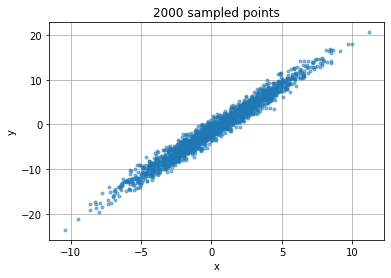

In [2]:
chosen_mu_x = 0.3
chosen_sig2_x = 10.0
chosen_eta = np.log(chosen_sig2_x)
#
chosen_eps2 = 1.3
chosen_lam = np.log(chosen_eps2)
#
chosen_beta = 2.0
chosen_alpha = -1.3
#
sample_count = 2000

# configure model
source_model = tfp.distributions.JointDistributionNamed({
    'x': tfp.distributions.Normal(chosen_mu_x, np.sqrt(chosen_sig2_x)),
    'y': lambda x: tfp.distributions.Normal((chosen_beta * x) + chosen_alpha, np.sqrt(chosen_eps2))
})

# generate data
sampled_data = source_model.sample(sample_count)
sampled_x_arr = sampled_data['x'].numpy()
sampled_y_arr = sampled_data['y'].numpy()

# visualize
fig, ax = pp.subplots(figsize=(6, 4))
#
ax.plot(sampled_x_arr, sampled_y_arr, '.', alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid()
ax.set_title(f'{sample_count} sampled points')

## Prior distribution 

Prior distribution will serve two functions
1. It will help to regularize the MCMC chain, preventing it from exploring un-interesting points
2. Initialize the MCMC chain from distributions based on point-estimates of the data

In [3]:
def get_data_point_estimates(
    x_data: np.ndarray,
    y_data: np.ndarray,
    bootstrap_iteration_count: int=10
)->tp.Dict[str, tp.Union[float, int]]:
    """
    Extract key point estimates from the data, which will then be used to configure prior distributions. Specifically
    will need:
        * \bar{x}: sample mean of x
        * s^2_x: sample variance of x
        * \bar{\beta}: sample mean of beta
        * \bar{\alpha}: sample mean of alpha
        * s^2_\beta: sample variance of beta
        * s^2_\alpha: sample variance of alpha
        * s^2_{y-beta*x-alpha}: sample variance of y-\bar{beta}*x-\bar{\alpha}
        
    Bootstrapping will be used to extract point-estimates for beta and alpha, i.e. data will be re-sampled with replacement
    then simple OLS will be used to extract beta and alpha, then point estimates will be extracted from that. This procedure,
    could actually be used as an alternative to extract distributions for beta and alpha, but the justification behind it would be
    shaky. Here the bootstrapping will be used to simply initialize MCMC chains, so slight errors at the start will should not
    affect the final result much.
    
    Arguments:
    ----------
        * x_data: array of x-data points (independent variable)
        * y_data: array of y-data points (linearly dependent on x)
        * bootstrap_iteration_count: number of times to sample from data to estimate alpha and beta statistics
        
    Returns:
    --------
        A dictionary with key estimates about the data:
            * sample_mean_x
            * sample_variance_x
            * sample_mean_beta
            * sample_variance_beta
            * sample_mean_alpha
            * sample_variance_alpha'
            * sample_variance_remainder
            * bootstrap_iteration_count
    """
    
    #### unbiased sample variance
    def sample_variance(arr):
        return np.sum((arr-np.mean(arr))**2)/(len(arr)-1)
    ####
    
    sample_mean_x = np.mean(x_data)
    sample_variance_x = sample_variance(x_data)
    
    # generate bootstrap data for beta and alpha
    beta_arr = np.zeros(bootstrap_iteration_count, dtype=float)
    alpha_arr = np.zeros(bootstrap_iteration_count, dtype=float)
    #
    for i_iter in range(bootstrap_iteration_count):
        # sample from data
        cur_index = npr.choice(len(x_data), len(x_data), replace=True)
        #
        cur_x_data = x_data[cur_index]
        cur_y_data = y_data[cur_index]
    
        # polyfit on extracted data
        pf = np.polyfit(cur_x_data, cur_y_data, deg=1)
        
        #store
        beta_arr[i_iter] = pf[0]
        alpha_arr[i_iter] = pf[1]
    
    # get point-estimates
    sample_mean_beta = np.mean(beta_arr)
    sample_variance_beta = sample_variance(beta_arr)
    #
    sample_mean_alpha = np.mean(alpha_arr)
    sample_variance_alpha = sample_variance(alpha_arr)
    
    # get estimate for the error in y
    remainder_arr = y_data - ( (sample_mean_beta * x_data) + sample_mean_alpha)
    sample_variance_remainder = sample_variance(remainder_arr)
    
    return {
        'sample_mean_x': sample_mean_x,
        'sample_variance_x': sample_variance_x,
        'sample_mean_beta': sample_mean_beta,
        'sample_variance_beta': sample_variance_beta,
        'sample_mean_alpha': sample_mean_alpha,
        'sample_variance_alpha': sample_variance_alpha,
        'sample_variance_remainder': sample_variance_remainder,
        'bootstrap_iteration_count': bootstrap_iteration_count
    }

#####################

def get_prior_distribution(
    sample_mean_x: float,
    sample_variance_x: float,
    sample_mean_beta: float,
    sample_variance_beta: float,
    sample_mean_alpha: float,
    sample_variance_alpha: float,
    sample_variance_remainder: float,
    prior_nu: int=1
)->tfp.distributions.JointDistribution:
    """
    Configure and return prior distribution for all key model parameters. This is used to both initialize the MCMC chains as well as to convert likelihood to posterior
    
    Arguments:
    ----------
        sample_mean_x: sample mean for x-data points
        sample_variance_x: ditto
        sample_mean_beta: sample mean for the greadient in the linear model
        sample_variance_beta: ditto
        sample_mean_alpha: sample mean for the intercept in the linear model
        sample_variance_alpha: ditto
        sample_variance_remainder: sample variance of the difference between Y and bar_beta*X+bar_alpha
        prior_nu: number of degrees of freedom. a convenience coefficient used to tighten the prior distribution
        
    Returns:
    ---------
        Initialized distribution for: 'lam', 'eta', 'alpha', 'beta', 'mu_x'
    """
    
    # sanitize inputs by wrapping them into tf
    # keep getting annoying error messages about float32/float64 conversions otherwise
    tf_prior_nu = tf.constant(prior_nu, dtype=tf.float32)
    #
    tf_sample_mean_x = tf.constant(sample_mean_x, dtype=tf.float32)
    tf_sample_variance_x = tf.constant(sample_variance_x, dtype=tf.float32)
    tf_sample_variance_remainder = tf.constant(sample_variance_remainder, dtype=tf.float32)
    #
    tf_sample_mean_beta = tf.constant(sample_mean_beta, dtype=tf.float32)
    tf_sample_variance_beta = tf.constant(sample_variance_beta, dtype=tf.float32)
    #
    tf_sample_mean_alpha = tf.constant(sample_mean_alpha, dtype=tf.float32)
    tf_sample_variance_alpha = tf.constant(sample_variance_alpha, dtype=tf.float32)
    #
    
    
    prior_distribution = tfp.distributions.JointDistributionNamed({
        'lam': tfp.distributions.ExpInverseGamma(tf_prior_nu/2., (tf_prior_nu * tf_sample_variance_remainder)/2.),
        'eta': tfp.distributions.ExpInverseGamma(tf_prior_nu/2., (tf_prior_nu * tf_sample_variance_x)/2.),
        #
        'beta': tfp.distributions.Normal(tf_sample_mean_beta, tf.sqrt(tf_sample_variance_beta/tf_prior_nu)),
        'alpha': tfp.distributions.Normal(tf_sample_mean_alpha, tf.sqrt(tf_sample_variance_alpha/tf_prior_nu)),
        #
        'mu_x': lambda eta: tfp.distributions.Normal(tf_sample_mean_x, tf.sqrt(tf.exp(eta)/tf_prior_nu))
    })
    
    return prior_distribution
        
##################

data_point_estimates_dict = get_data_point_estimates(sampled_x_arr, sampled_y_arr)
    
prior_distribution = get_prior_distribution(
    sample_mean_x=data_point_estimates_dict['sample_mean_x'],
    sample_variance_x=data_point_estimates_dict['sample_variance_x'],
    sample_mean_beta=data_point_estimates_dict['sample_mean_beta'],
    sample_variance_beta=data_point_estimates_dict['sample_variance_beta'],
    sample_mean_alpha=data_point_estimates_dict['sample_mean_alpha'],
    sample_variance_alpha=data_point_estimates_dict['sample_variance_alpha'],
    sample_variance_remainder=data_point_estimates_dict['sample_variance_remainder'],
    prior_nu=1
)

print('Data stats:')
print(data_point_estimates_dict)

print('\nSampled prior:')
print(prior_distribution.sample(3))

Data stats:
{'sample_mean_x': 0.2859236383446509, 'sample_variance_x': 9.859353531823032, 'sample_mean_beta': 2.0143022519987164, 'sample_variance_beta': 4.4603193242664756e-05, 'sample_mean_alpha': -1.321481510687034, 'sample_variance_alpha': 0.0007948978823119262, 'sample_variance_remainder': 1.360964854925926, 'bootstrap_iteration_count': 10}

Sampled prior:
{'eta': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([3.5729337, 3.9085815, 2.812755 ], dtype=float32)>, 'mu_x': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 3.2431898, -2.3593407,  0.6445972], dtype=float32)>, 'lam': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.51158625,  3.0862107 ,  0.62217426], dtype=float32)>, 'beta': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([2.0261045, 2.0017002, 2.0061612], dtype=float32)>, 'alpha': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.2733927, -1.3768444, -1.350241 ], dtype=float32)>}


2021-11-02 12:09:28.639818: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


## Log-Likelihood & Posterior

In [4]:
def log_lkhd(
    lam: tf.Tensor,
    eta: tf.Tensor,
    beta: tf.Tensor,
    alpha: tf.Tensor,
    mu_x: tf.Tensor,
    #
    x_data: tf.Tensor,
    y_data: tf.Tensor
)->tf.Tensor:
    """
    Compute log-likelihood for all the data-points for the given set of parameters. The input model parameters can have any shape (tf.Tensors), 
    the input data must be tf.Tensors with one dimension. Returned log-likelihood will be of the same shape as input model parameters
    
    Assumed probabilistic model is:
    
    x ~ N(mu_x, exp(eta))
    y ~ N(beta*x+alpha, exp(lam))
    
    Arguments:
    ----------
        lam: logarithm of the variance of y-x*beta-alpha
        eta: logarith of the variance of x
        beta: gradient coefficient
        alpha: intercept coefficient
        mu_x: mean for the normal distirbuion of x
        x_data: input data x-points
        y_data: input data y-points
        
    Returns:
    --------
        log-likelihood tensor with the same shape as lam etc
    """
    
    # reshape to have data running along the zeroth axis, with other parameters running along later axis
    x_data_reshaped = tf.reshape(x_data, [x_data.shape[0], *[1 for _ in lam.shape]])
    y_data_reshaped = tf.reshape(y_data, [y_data.shape[0], *[1 for _ in lam.shape]])
    
    # define probabilistic model
    # bear in mind that convention of TFP is to specify Normal models via standard deviation (not variance)
    data_model = tfp.distributions.JointDistributionNamed({
        'x': tfp.distributions.Normal(mu_x, tf.exp(eta/2.)),
        'y': lambda x: tfp.distributions.Normal((beta*x)+alpha, tf.exp(lam/2.))
    })
    
    # compute log-likelihood
    log_lkhd_per_sample = data_model.log_prob(x=x_data_reshaped, y=y_data_reshaped)
    
    # collapse along zeroth dimension, to get probability for all data points
    log_lkhd_agg = tf.reduce_sum(log_lkhd_per_sample, axis=0)
    
    return log_lkhd_agg

######

def log_post_prob(
    lam: tf.Tensor,
    eta: tf.Tensor,
    beta: tf.Tensor,
    alpha: tf.Tensor,
    mu_x: tf.Tensor,
    #
    x_data: tf.Tensor,
    y_data: tf.Tensor,
    #
    prior_distribution: tfp.distributions.JointDistribution,
    log_lkhd_func: tp.Callable[[tf.Tensor]*7, tf.Tensor],
)->tf.Tensor:
    """
    Compute log of non-normalized posterior distribution given prior, data and likelihood
    
    Arguments:
    ----------
        lam: logarithm of the variance of y-x*beta-alpha
        eta: logarith of the variance of x
        beta: gradient coefficient
        alpha: intercept coefficient
        mu_x: mean for the normal distirbuion of x
        x_data: input data x-points
        y_data: input data y-points
        prior_distribution: Joint prior probability distribution for the data. Should take in `lam`, `eta`, `beta`, `alpha`, `mu_x` 
            as inputs and return log-probability of prior beliefs (via `log_prob`)
            
        log_lkhd_func: function that takes in mu, `lam`, `eta`, `beta`, `alpha`, `mu_x`, `data_x`, `data_y`, as tensors, and returns the 
            log-likelihood for all the data points. See `log_lkhd`
        data: (N,)-shaped tensor of data points for N data points
        
    Returns:
    --------
        tensor of posterior log-probabilities, that is shaped like `lam` etc
    """
    
    # compute prior log-probability
    log_prior_tens = prior_distribution.log_prob(
        lam=lam,
        eta=eta,
        beta=beta,
        alpha=alpha,
        mu_x=mu_x
    )
    
    # compute likelihood
    log_lkhd_tens = log_lkhd_func(
        lam=lam,
        eta=eta,
        beta=beta,
        alpha=alpha,
        mu_x=mu_x,
        x_data=x_data,
        y_data=y_data
    )
    
    # compute posterior log-prob
    log_post_tens = log_lkhd_tens + log_prior_tens
    
    return log_post_tens

##################

data_point_estimates_dict = get_data_point_estimates(sampled_x_arr, sampled_y_arr)
    
prior_distribution = get_prior_distribution(
    sample_mean_x=data_point_estimates_dict['sample_mean_x'],
    sample_variance_x=data_point_estimates_dict['sample_variance_x'],
    sample_mean_beta=data_point_estimates_dict['sample_mean_beta'],
    sample_variance_beta=data_point_estimates_dict['sample_variance_beta'],
    sample_mean_alpha=data_point_estimates_dict['sample_mean_alpha'],
    sample_variance_alpha=data_point_estimates_dict['sample_variance_alpha'],
    sample_variance_remainder=data_point_estimates_dict['sample_variance_remainder'],
    prior_nu=1
)

log_post_prob(
    lam=tf.constant([6.6]*2, dtype=tf.float32),
    eta=tf.constant([1.6]*2, dtype=tf.float32),
    beta=tf.constant([2.0]*2, dtype=tf.float32),
    alpha=tf.constant([-1.3]*2, dtype=tf.float32),
    mu_x=tf.constant([1.4]*2, dtype=tf.float32),
    x_data=tf.constant(sampled_x_arr, dtype=tf.float32),
    y_data=tf.constant(sampled_y_arr, dtype=tf.float32),
    prior_distribution=prior_distribution,
    log_lkhd_func=log_lkhd
)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-14119.193, -14119.193], dtype=float32)>

## MCMC sampling

In [5]:
######### HMC
@tf.function(jit_compile=True)
def hmc_mcmc_sample(
    log_post_func: tp.Callable[[tf.Tensor]*5, tf.Tensor],
    init_state: tp.List[tf.Tensor],
    num_burnin_steps: int=1000,
    num_results: int=100,
    step_size: float=0.05,
    num_leapfrog_steps=3,
)->tf.Tensor:
    """
    Run MCMC using basic Hamiltonian Monte-Carlo
    
    Arguments:
    ----------
        log_post_func: function that accepts tensors for mu and lam and returns log-probability for the posterior
        init_state: initial state for MCMC, for mu and lam, eta, beta, alpha, mu_x with shapes (K, 1) where K is the number
                    of chains
        num_burnin_steps: number of burn-in steps see `tensorflow_probability.mcmc.sample_chain`
        num_results: number of results per chain see `tensorflow_probability.mcmc.sample_chain`
        step_size: size of the step for HMC
        num_leapfrog_steps: see HMC
        
    Returns:
    --------
        A list of tensors ([lam, eta, beta, alpha, mu_x]) with the results. The shape of the tensors includes number of results and 
        number of chains
    """
    
    # basic kernel
    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=log_post_func,
        num_leapfrog_steps=num_leapfrog_steps,
        step_size=step_size
    )
    
    ahmc_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=hmc_kernel,
        num_adaptation_steps=int(num_burnin_steps * 0.8)
    )
    
    sampled_chain = tfp.mcmc.sample_chain(
        kernel=ahmc_kernel,
        trace_fn=None,
        current_state=init_state,
        num_burnin_steps=num_burnin_steps,
        num_results=num_results
    )
    
    return sampled_chain


##########################

# limit the number of points used to estimate prior
limit_for_pior = 20
data_point_estimates_dict = get_data_point_estimates(sampled_x_arr[:limit_for_pior], sampled_y_arr[:limit_for_pior])
    
prior_distribution = get_prior_distribution(
    sample_mean_x=data_point_estimates_dict['sample_mean_x'],
    sample_variance_x=data_point_estimates_dict['sample_variance_x'],
    sample_mean_beta=data_point_estimates_dict['sample_mean_beta'],
    sample_variance_beta=data_point_estimates_dict['sample_variance_beta'],
    sample_mean_alpha=data_point_estimates_dict['sample_mean_alpha'],
    sample_variance_alpha=data_point_estimates_dict['sample_variance_alpha'],
    sample_variance_remainder=data_point_estimates_dict['sample_variance_remainder'],
    prior_nu=1
)

# rig the posterior log-probability so that it only needs
# key inputs
rigged_log_post_func = lambda lam, eta, beta, alpha, mu_x: \
    log_post_prob(
        lam=lam,
        eta=eta,
        beta=beta,
        alpha=alpha,
        mu_x=mu_x,
        x_data=tf.constant(sampled_x_arr, dtype=tf.float32),
        y_data=tf.constant(sampled_y_arr, dtype=tf.float32),
        prior_distribution=prior_distribution,
        log_lkhd_func=log_lkhd
    )

# set-up initial state
# list of tensors, one tensor per parameter
# the shape of the tensors should be (*, 1) where the number of elements along the zeroth
# dimension determines the number of chains
chain_count = 50
# will initialize chains from prior
initial_tens_dict = prior_distribution.sample(chain_count)

param_order_list = ['lam', 'eta', 'beta', 'alpha', 'mu_x']
mcmc_init_state = [
    tf.reshape(initial_tens_dict[key], shape=[chain_count, 1])
    for key in param_order_list
]

num_burnin_steps = 10000
samples_per_chain = 1000

####
print('Running chain')

# run the chain
sampler_choice = 'hmc'

if sampler_choice == 'hmc':
    pass
    chain_list = hmc_mcmc_sample(
        log_post_func=rigged_log_post_func,
        init_state=mcmc_init_state,
        num_burnin_steps=num_burnin_steps,
        num_results=samples_per_chain,
        step_size=10.00,
        num_leapfrog_steps=3
    )
else:
    raise Exception('Not implemented')

print('Done')

Running chain


2021-11-02 12:09:30.155809: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x55a5e1a33830 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-11-02 12:09:30.155835: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Host, Default Version
2021-11-02 12:09:30.243634: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2021-11-02 12:09:30.390768: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:96] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed
2021-11-02 12:09:36.022333: I tensorflow/compiler/jit/xla_compilation_cache.cc:363] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Done


In [6]:
# unpack to dictionary
#
results_dict = {
    key: chain_list[i_key]
    for i_key, key in enumerate(param_order_list)
}

results_dict['sig2_x'] = tf.exp(results_dict['eta'])
results_dict['eps2'] = tf.exp(results_dict['lam'])

## Inspect results 

Start by looking at individual distirbutions

(0.31387361884117126, 1.435658211708069)

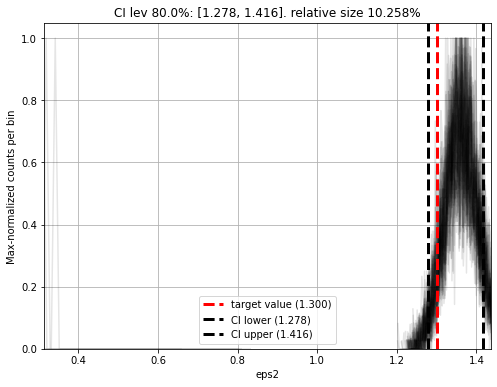

In [17]:
key_param = 'eps2'
param_arr = np.squeeze(results_dict[key_param].numpy())

target_val_dict = {
    'alpha': chosen_alpha,
    'beta': chosen_beta,
    'sig2_x': chosen_sig2_x,
    'eps2': chosen_eps2,
    'eta': chosen_eta,
    'lam': chosen_lam,
    'mu_x': chosen_mu_x
}

ci_lev = 0.80
ci_lim = [(1-ci_lev)/2, 1-(1-ci_lev)/2]
bin_count = int(samples_per_chain/10)

#### plot

fig, ax = pp.subplots(figsize=(8, 6))

for i_chain in range(chain_count):
    cur_chain = param_arr[:, i_chain]
    
    hist_counts, hist_bins = np.histogram(cur_chain, bins=bin_count)
    hist_bin_mid_points = (hist_bins[1:] + hist_bins[:-1])/2
    
    ax.plot(hist_bin_mid_points, hist_counts/np.max(hist_counts), color='k', alpha=0.1)
    ax.set_ylim([0, 1.05])
    
    
# add some reference info
ax.axvline(target_val_dict[key_param], color='red', linewidth=3, linestyle='--', label=f'target value ({target_val_dict[key_param]:.3f})')
ax.axvline(np.quantile(param_arr, ci_lim[0]), color='k', linewidth=3, linestyle='--', label=f'CI lower ({np.quantile(param_arr, ci_lim[0]):.3f})')
ax.axvline(np.quantile(param_arr, ci_lim[1]), color='k', linewidth=3, linestyle='--', label=f'CI upper ({np.quantile(param_arr, ci_lim[1]):.3f})')
ax.set_xlabel(key_param)
ax.grid()
ci_lim_real = np.quantile(param_arr, ci_lim)
ax.set_title(f'CI lev {ci_lev*100:.1f}%: [{ci_lim_real[0]:.3f}, {ci_lim_real[1]:.3f}]. '+\
            f'relative size {np.abs((ci_lim_real[1]-ci_lim_real[0])/((ci_lim_real[0]+ci_lim_real[1])/2)*100):.3f}%')
ax.legend()
ax.set_ylabel('Max-normalized counts per bin')
ax.set_xlim(np.quantile(param_arr, [0.045, 0.955]))

A more interesting question is on the joint distribution of different parameters since that was not at all set-up from the initial point estimates

Text(0, 0.5, 'beta')

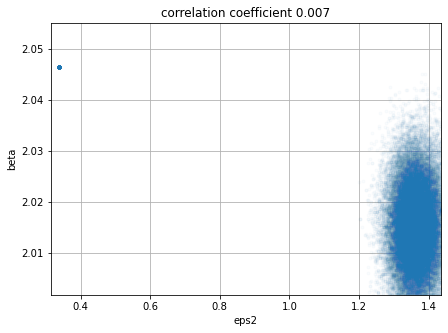

In [22]:
joint_name_hor = 'eps2'
joint_name_vert = 'beta'

joint_arr = np.stack([
    results_dict[joint_name_hor].numpy().reshape(-1),
    results_dict[joint_name_vert].numpy().reshape(-1)
],  axis=1)

fig, ax = pp.subplots(figsize=(7, 5))
#
ax.plot(joint_arr[:,0], joint_arr[:,1], '.', alpha=0.02)
ax.set_xlim(np.quantile(joint_arr[:,0], [0.045, 0.955]))
ax.set_ylim(np.quantile(joint_arr[:,1], [0.045, 0.955]))

# work out correlation coefficient, drop outliears using quatiles
ci_lev = 0.8
ci_lim = [(1-ci_lev)/2, 1-(1-ci_lev)/2]
il_good_hor = ( (joint_arr[:,0]>np.quantile(joint_arr[:,0], ci_lim[0])) & (joint_arr[:,0]<np.quantile(joint_arr[:,0], ci_lim[1])) )
il_good_vert = ( (joint_arr[:,1]>np.quantile(joint_arr[:,1], ci_lim[0])) & (joint_arr[:,1]<np.quantile(joint_arr[:,1], ci_lim[1])) )

reduced_joint_arr = joint_arr[il_good_vert & il_good_hor, :]

joint_corr = np.corrcoef(reduced_joint_arr[:,0], reduced_joint_arr[:,1])[0,1]

ax.set_title(f'correlation coefficient {joint_corr:.3f}')
ax.grid()
ax.set_xlabel(joint_name_hor)
ax.set_ylabel(joint_name_vert)

Alas, no interesting correlation seems to arrise